### Paper Topic: Model Selection for Gaussian Processes Utilizing Sensitivity of Posterior Predictive Distribution
- Shaan Desai, Spencer Hallyburton, Salvador Barragan

#### Introduction

- Feature selection in machine learning is an important method used to select a subset of the most relevant features for a given response. This is particularly useful, but not limited to, situations in which deep knowledge of the problem domain is unknown or limited and an interpretable, low dimensional model needs to be built.
- Over the years numerous methods have been developed to carry out automatic feature selection such as forward/backward selection, lasso/ridge regression, correlation matrices etc. However, significant research continues to go into feature selection methods since different methods produce different results in high dimensional problems.
- In this discussion we focus on two methods recently presented by Paananen et al for feature selection in Gaussian Process (GP) methods. Their basic idea is to use variations in the posterior predictive distribution with respect to each feature to pick out the relevances of individual features. They present two novel variable selection methods'. The first method (KL) relies on KL divergence of the posterior predictive at the training points compared to the training points with one feature slightly perturbed. The second method (VAR) relies on the posterior predictive mean and computes the relevances of each feature based on the variance along a covariate.
- We outline both these methods in detail herein and implement them in GPy, the framework Paananen used to build these models.



#### Background Information

- As a refresher, gaussian processes are a non parametric class of models which define a distribution over functions [Paananen et al].
- priors are functions where $p(f) = N(\mu,K)$ where mu is a vector of means and K is a measure of the covariance matrix with a specific kernel e.g. RBF.
- With a given set of parameters for the kernel one can construct a whole set of functions across numerous data points refered to as latent functions.
- Then, we introduce data. In our case, we introduce training data. The introduction of data is treated as extending the Normal of the prior distribution to include the means and covariances of the specified points s.t.:

$$ \begin{bmatrix} f \\ y \end{bmatrix} \sim N \Bigg(\begin{bmatrix} 0 \\ 0 \end{bmatrix} , \begin{bmatrix} K + \sigma^2I & K_{*}^T \\ K_{*} & K_{**} \end{bmatrix}\Bigg)  $$


The posterior predictive is then simply a conditional which is also gaussian!

$$ P(y|f) = N(\mu_a,\Sigma_a) $$


where:

$$ \mu_a = K_{*}(K+\sigma^2I)^{-1}y $$

$$ \Sigma_{a} = K_{**} -K_{*}(K+\sigma^2I)K_{*}^T $$

- One measure of relevance we can derive from this fitting procedure (through MLE) is Automatic relevance determination, a method we will refer to as the most natural way to determine feature importance. ARD is simply calculated by looking at the optimized RBF kernel length (l) in:

$$k(x,x') = \sigma^2 exp\bigg(-\frac{1}{2} \frac{(x-x')^2}{l^2}\bigg) $$

Using a separate length for each feature (and a hence a separate covariance matrix for each feature) we can determine the ARD by taking the reciprocal of the length scale, l, as a measure of relevance since lower length scales mean highly relevant features. ARD forms the baseline of our experiments as it does in Paananen et al and is a good way to compare the performance of the new methods introduced.

#### Procedure

##### Method 1: KL 

KL divergence is a good metric to determine the difference between two distributions. As such, Paananen et al suggest a unique and simple way to determine feature importance using this divergence on the posterior predictive distribution. Earlier, we mentioned that the posterior predictive distribution in gaussian processes is simply a conditional of P(y,f) which we already know is Gaussian. We can simply take this posterior distribution at the training points X (where X= [$x_1$,$x_2$,....$x_{feature n}$] and is of dimension observations by number of features) and compare it to a posterior predictive distribution in which feature $x_j$ is perturbed by an amount $\Delta$ (~ 0.0001). The idea in doing this is that if the feature $x_j$ is important, then the KL divergence between a distribution with $x_j$ and $x_j + \Delta$ should be high and the higher the divergence the more important the feature. Since both of these posterior distributions will be gaussian with a specific mu and sigma as presented earlier, we can compute the KL analytically in this form:

$$ KL(N1,N2) = log\frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 +(\mu_1-\mu_2)^2}{2\sigma_2^2} - 1/2 $$

Simpson et al suggest that a distance between distributions can be computed using:

$$ d = \sqrt{2KL(N1,N2)} $$

and the relevance Paananen develops from this is to simply divide d by $\Delta$ s.t:

$$ KL_{relevance} = \frac{\sqrt{2KL(N1,N2)}}{\Delta} $$


##### Method 2: VAR

The core idea in this method is to use the variance of the posterior predictive mean of a full GP along each covariate as an estimate for the relevance of the covariate. The idea is that we know:

$$ p(y|f) \sim N(\mu_{*},\Sigma_{*}) $$ where
$$ \mu_{*} = K_{*}(K+\sigma^2I)^{-1}y $$

Now imagine that y is one data point e.g. (1 row of 8 features) then posterior predictive mean is calculated using that one row and the training points in f. Now if we ask, what is the variance of this mu then we would need to know the distribution of our features X because mu is basically a function of X. To do this we need to know how our X's are distributed. We assume that these x's are distributed Normally s.t. $X\sim N(\mu,\Sigma)$. But, we can also get more granular than this, since the conditional of this along one covariate is also Normal e.g.

$$ \begin{bmatrix} x_{-j} \\ x_j \end{bmatrix} \sim N \Bigg(\begin{bmatrix} \mu_{-j} \\ \mu_j \end{bmatrix} , \begin{bmatrix} \Sigma_{-j,-j} & \sigma_{j,-j} \\ \sigma_{-j,j} & \sigma_{j,j} \end{bmatrix}\Bigg)  $$


Thus we can take the conditional distribution which is normal:

$$ p(x_j|x_{-j}) = N(\mu_a,\sigma_a^2) $$

where

$$ \mu_a = \mu_j + \sigma_{j,-j} \Sigma_{-j,-j}^{-1} (x_{-j}-\mu_{-j}) $$

$$ \sigma_a^2 = \sigma_{j,j} - \sigma_{j,-j} \Sigma_{-j,-j}^{-1} \sigma_{-j,j} $$


Great, now we have a distribution of the inputs and the distribution of a single input given the others. With this, we can determine the Variance of $\mu_{*}$ with respect to a single covariate/feature. The equation is thus:

$$ Var(\mu_{*}(x_j)) = \int \mu_{*}^2 N(\mu_a,\sigma_a^2) dx_j - \Bigg(\int \mu_{*} N(\mu_a,\sigma_a^2)dx_j\Bigg)^2 $$

With some variable changes we can get:

$$ k = (x_j - \mu_a)/(\sqrt{2}\sigma_a) $$

Thus the variance becomes:


$$ Var(\mu_{*}(x_j)) \approx \pi^{-1/2} \Sigma_{i=1}^n w_i \mu_{*}^2 (\sqrt{2} \sigma_a k_i + \mu_a) - \pi^{-1} ( \Sigma_{i=1}^{n} w_i \mu_{*} (\sqrt{2}\sigma_a k_i + \mu_a))^2 $$

where w_i and k_i are weights and evaluation points of the Gauss-Hermite quadrature.


#### Code








In [195]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import GPy
from tqdm import tqdm
import scipy as scp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#### Initial testing to generate the figures in fig1

In [196]:
#8*1000 random vars, 8 input vectors/features
xjs_unif = np.random.uniform(-1.,1.,(8,300))
xjs_norm = np.random.normal(0,0.4,(8,300))

#8 uniform coefficients of sine function for the 8 functions
phi = np.linspace(np.pi/10,np.pi,8)
#compute input of sines = phij*xj for each j
inp_unif = []
inp_norm = []
for i in range(8):
    inp_unif.append(phi[i]*xjs_unif[i,:])
    inp_norm.append(phi[i]*xjs_norm[i,:])
inp_unif = np.array(inp_unif)
inp_norm = np.array(inp_norm)
sines_unif = np.sin(inp_unif)
sines_norm = np.sin(inp_norm)

#compute function coeffs Aj by finding the std of sin(phij*xj) and taking 1/std(sin(phij*xj))
fjunif = []
fjnorm = []
for i in range(8):
    fjunif.append(sines_unif[i,:]/np.std(sines_unif[i,:]))
    fjnorm.append(sines_norm[i,:]/np.std(sines_norm[i,:]))
fjunif = np.array(fjunif)
fjnorm = np.array(fjnorm)

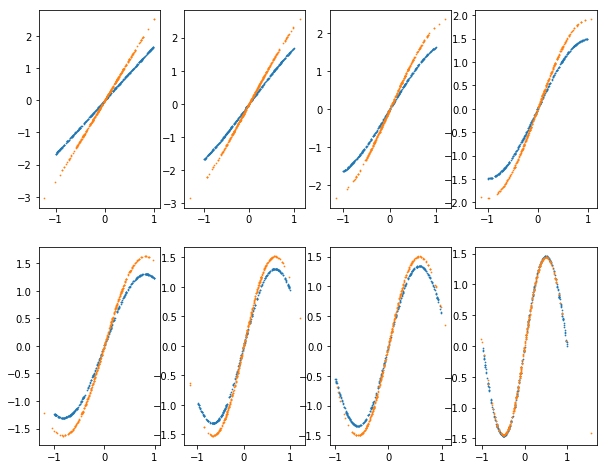

In [197]:
fig,ax = plt.subplots(2,4,figsize=(10,8))
ax = ax.ravel()
for i in range(8):
    ax[i].scatter(xjs_unif[i,:],fjunif[i,:],s=0.5)
    ax[i].scatter(xjs_norm[i,:],fjnorm[i,:],s=0.5)

In [198]:
# define both functions to compute relevances

def KLmethod(X,m):
    """computes the KL divergence between original training points and each covariate perturbed
    e.g. X= [x1,x2,..xn] and Xd = [x1+delta,x2,x3..]"""
    # Delta for KL method
    delta = 0.0001
    
    #KL divergence
    def KL(mu1,s1,mu2,s2):
        return (np.log(s2/s1) +(s1**2+(mu1-mu2)**2)/(2*s2**2)- 1./2)

    #relevance metric
    def rrel_fun(mu1,s1,mu2,s2):
        return (np.sqrt(2*KL(mu1,s1,mu2,s2))/delta)
    
    
    #number of training points
    n = X.shape[0]
    #number of features
    p = X.shape[1]
    
    #loop over training data points and perturb each 
    relsup = np.zeros((n,p))
    relsdn = np.zeros((n,p))
    muorig,varorig = m.predict(X)
    for i in range(p):
        #do positive delta perturbation
        X[:,i] = X[:,i] + delta
        muu,Cu = m.predict(X)
        #negative delta perturb
        X[:,i] = X[:,i] - 2*delta
        mud,Cd = m.predict(X)
        #compute relevances for top and bottom
        relsup[:,i] = rrel_fun(muorig,np.sqrt(varorig),muu,np.sqrt(Cu)).ravel()
        relsdn[:,i] = rrel_fun(muorig,np.sqrt(varorig),mud,np.sqrt(Cd)).ravel()
        #return to original vector
        X[:,i] = X[:,i] + delta
    return np.mean((relsup + relsdn)/2,axis=0)
    

# Function adapted from Paananen
# https://github.com/topipa/GP_varsel_KL_VAR/blob/master/code/GP_varsel.py
def VARmethod(X,model,nquadr):
    """Computes relevance by looking at variance of posterior predictive mean at x_j, holding x_-j constant"""
    
    # Auxiliary functions

    def cholr1update(L,x):
        """Computes a rank-1 update to a Cholesky decomposition"""
        n = np.shape(x)[0]
        for k in np.arange(0,n):
            r = np.sqrt(L[k,k]*L[k,k] + x[k]*x[k])
            c = r / L[k,k]
            s = x[k] / L[k,k]
            L[k,k] = r
            L[k+1:,k] = (L[k+1:,k] + s * x[k+1:]) / c
            x[k+1:] = c * x[k+1:] - s * L[k+1:,k]
        return L

    def cholsubmatrix(L,index):
        """Computes the Cholesky decomposition for a submatrix (matrix with one row and one column removed) 
        using the Cholesky of the full matrix"""
        n = np.shape(L)[0]
        chol = np.zeros((n-1,n-1)) 
        chol[:index,:index] = L[:index,:index]
        if (index < n-1):
            chol[index:,:index] = L[index+1:,:index]
            chol[index:,index:] = cholr1update(L[index+1:,index+1:],L[index+1:,index])
        return chol 
    
    
    n = X.shape[0]
    p = X.shape[1]
    relevances = np.zeros(p)
    [points,weights] = np.polynomial.hermite.hermgauss(nquadr)
    
    jitter=1e-9
    
    # full covariance matrix of X plus small jitter on diagonal
    fullcov = np.cov(X,rowvar=False) + jitter*np.eye(p)

    # if condition number is high, add a diagonal term until it goes below 100
    # this is a bit heuristic
    while (np.linalg.cond(fullcov,p=2) > 100):
        jitter = jitter*10
        fullcov = fullcov + jitter*np.eye(p)

    # Cholesky decomposition of the covariance matrix
    cholfull = scp.linalg.cholesky(fullcov,lower=True)

    # loop through covariates
    for j in range(0, p):

        # remove j'th covariate
        jvals = X[:,j]
        nojvals = np.delete(X,(j), axis=1)
        jmean = jvals.mean() 
        nojmean = nojvals.mean(axis=0)

        jcov = fullcov[j,j]
        jnojcov = fullcov[j,:]
        jnojcov = np.delete(jnojcov,(j),axis=0)
        jnojcov = jnojcov.reshape(1,p-1)
        
        # Cholesky decomposition of the submatrix
        cholsub = cholsubmatrix(cholfull,j)
        meanfactor = scp.linalg.cho_solve((cholsub,True),jnojcov.T).T
        intcov = jcov - np.dot(  meanfactor,jnojcov.T)

        # loop through data points
        for k in range(0, n):

            nojtark = nojvals[k,:]
            intmean = jmean + np.dot(meanfactor,(nojtark - nojmean))
            fcalcpoints = np.repeat(X[k,:],nquadr).reshape(p,nquadr).T
            fcalcpoints[:,j] = np.sqrt(2)*np.sqrt(intcov)*points + intmean

            predmean,predvar = GPy.models.GPRegression.predict(model,fcalcpoints,full_cov=False)
            fsquare = predmean*predmean

            # Gauss-Hermite quadrature integration
            relevances[j] += np.dot(fsquare.T,weights)/np.sqrt(np.pi) - np.dot(predmean.T,weights)*np.dot(predmean.T,weights)/np.pi

    return relevances/n

In [203]:
# number of repetitions to average over
repeats = 10
# number of covariates
m = 8
# number of data points
n = 300
# Delta for KL method
delta = 0.0001
# number of quadrature points for VAR method
#nquadr = 11

# compute the analytical scaling coefficients for the m components
phi = np.pi*np.linspace(0.1,1,m);
anaA = np.zeros(m)
for i in range(0,m):
    anaA[i] = np.sqrt( 4/(2 -1/phi[i]*np.sin(2*phi[i])) )

# Input data
x_all = [np.random.uniform(-1.,1.,(n,m,repeats)), np.random.normal(0,0.4,(n,m,repeats))]
rel_ARD_all = []
rel_KL_all = []
rel_VAR_all = []

# Loop over different types of input data
for ii, x_data in enumerate(x_all):
    rel_ARD_toy = np.zeros(m)
    rel_KL_toy = np.zeros(m)
    rel_VAR_toy = np.zeros(m)
    # Perform the specified number of repeat trials
    for i in tqdm(range(0, repeats)):
        x = x_data[:,:,i]
        
        phi = np.tile(np.linspace(np.pi/10,np.pi,m),(n,1))
        xphi = np.multiply(x[:,0:m],phi)
        f = np.sin(xphi)
        for j in range(0,m):
            f[:,j] = f[:,j]*anaA[j]    

        # y is a sum of the m components plus Gaussian noise
        yval = f.sum(axis=1) + np.random.normal(0,0.3,(n,))
        y = np.asmatrix(yval).T

        # RBF kernel plus constant term
        kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)
        model = GPy.models.GPRegression(x,y,kernel)
        model.optimize()

        # ARD relevance value is the inverse of the length scale
        rel_ARD_toy = rel_ARD_toy + 1/model.sum.rbf.lengthscale

        # KL relevance value
        rel_KL_toy = rel_KL_toy + KLmethod(x,model)

        #var rel
        rel_VAR_toy = rel_VAR_toy + VARmethod(x,model,11)
        
    # Store the relevance measurements
    rel_ARD_all.append(rel_ARD_toy)
    rel_KL_all.append(rel_KL_toy)
    rel_VAR_all.append(rel_VAR_toy)

100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


In [205]:
def plot_relevance(ax, rel_ARD, rel_KL, rel_VAR, title):
    xlength = range(1, len(rel_ARD)+1)
    
    # First axis - Uniform feature inputs
    ax.plot(xlength,np.ones(len(xlength)), '--ko', c='k', label='True Relevance')
    ax.plot(xlength,rel_ARD/rel_ARD.max(),'-o',c='b',label='ARD')
    ax.plot(xlength,rel_KL/rel_KL.max(),'-o',c='r',label='KL')
    ax.plot(xlength,rel_VAR/rel_VAR.max(),'-o',c='purple',label='VAR')
    ax.set_ylabel('Relevance')
    ax.set_title(title)
    ax.set_ylim([0,1.1])
    ax.legend()

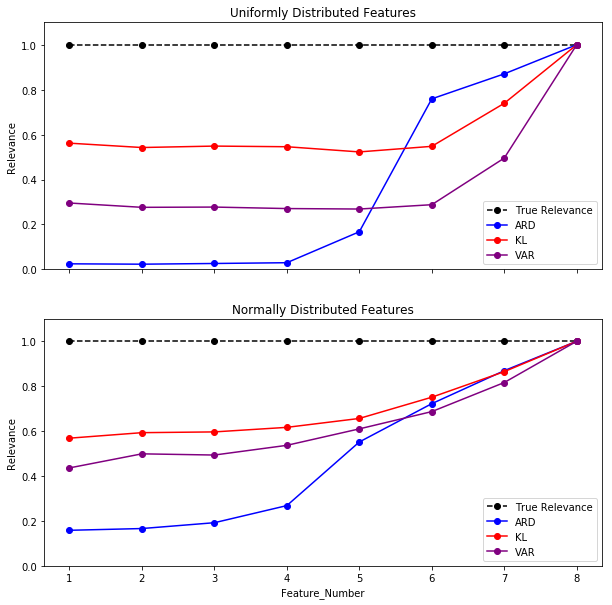

In [206]:
titles=['Uniformly Distributed Features', 'Normally Distributed Features']

# Plotting routines
fig, ax = plt.subplots(2,1,figsize=(10,10),sharex=True)
for i, (rel_ARD_temp, rel_KL_temp, rel_VAR_temp) in enumerate(zip(rel_ARD_all, rel_KL_all, rel_VAR_all)):
    plot_relevance(ax[i], rel_ARD_temp, rel_KL_temp, rel_VAR_temp, titles[i])
plt.xlabel('Feature_Number')
plt.show()

#### Real-World Datasets

In [71]:
def preprocess_data(X, y):
    # Normalize the data
    X = preprocessing.scale(X)
    y = preprocessing.scale(y)
    
    # Train-test split on the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

        # If y_train is one dimensional, reshape it as 2
    if len(y_train.shape)==1:
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
        
    return X_train, X_test, y_train, y_test 

In [76]:
def perform_GP_fitting(X, y):
    
    # number of repetitions to average over
    repeats = 10

    # Train-test split (only for getting dimensions, will be repeated every iteration)
    Xdata, Xtest, ydata, ytest = preprocess_data(X, y)

    # Get sizes of data
    n, m = Xdata.shape
    n2, m2 = Xtest.shape

    # Initialize arrays for results
    rel_ARD = np.zeros(m)
    rel_KL = np.zeros(m)
    rel_VAR = np.zeros(m)

    # Initialize place to store output
    nmetrics = 3
    mlpd = np.zeros((m, nmetrics, repeats))
    
    # Priors:
    var_prior = GPy.priors.Gamma(a=1.0, b=10.0)
    noise_prior = GPy.priors.Gaussian(mu=0., sigma=0.2)
    len_prior = GPy.priors.Gamma(a=1.0, b=10.0)

    # Run the full model:
    print('Testing full model')
    for i in tqdm(range(0, repeats)):
        
        # Split the data now for every repitition
        Xdata, Xtest, ydata, ytest = preprocess_data(X, y)

        # RBF kernel plus constant term
        kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)

        # Initialize the model
        model = GPy.models.GPRegression(Xdata, ydata, kernel)
        
        # Set the priors
        #model.sum.rbf.lengthscale.set_prior(len_prior)
        #model.sum.rbf.variance.set_prior(var_prior)
        #model.Gaussian_noise.variance.set_prior(noise_prior)
        
        # Optimize the model
        model.optimize()

        # ARD relevance value is the inverse of the length scale
        rel_ARD = rel_ARD + 1/model.sum.rbf.lengthscale
        
        # KL relevance value
        rel_KL = rel_KL + KLmethod(Xdata,model)

        #var rel
        rel_VAR = rel_VAR + VARmethod(Xdata,model,11)

        # Calculate the predictive density
        mlpd[-1, :, i] = np.mean(model.log_predictive_density(Xtest, ytest))
        
        
    # Calculate the ordering and run the model over all of the different orders
    print('Testing Covariates')
    for j, sort_rel_metric in enumerate([rel_ARD, rel_KL, rel_VAR]):
        print(j)

        # Get the ordering for this model
        #ordering = np.argsort(sort_rel_metric)  is this the reverse order?? 
        ordering = list(reversed(np.argsort(sort_rel_metric)))
        print(ordering)

        # Loop in reverse over the number of features except for the full model
        for nfeat in reversed(range(1,m)):
            print('Number of Features:', nfeat)

            # Reslice the data based on the ordering:
            X_sub = X.values[:, ordering[:nfeat]]

            # Perform the specified number of repeat trials
            for i in range(0, repeats):
                
                # Split the data now for every repitition
                Xdata, Xtest, ydata, ytest = preprocess_data(X_sub, y.values)
                
                # RBF kernel plus constant term
                kernel = GPy.kern.RBF(input_dim=nfeat,ARD=True) + GPy.kern.Bias(input_dim=nfeat)
                model = GPy.models.GPRegression(Xdata, ydata, kernel)

                # Set the priors
                #model.sum.rbf.lengthscale.set_prior(len_prior)
                #model.sum.rbf.variance.set_prior(var_prior)
                #model.Gaussian_noise.variance.set_prior(noise_prior)

                model.optimize()

                # Make the predictions:
                mlpd[nfeat-1, j, i] = np.mean(model.log_predictive_density(Xtest, ytest))
    return mlpd

In [87]:
def plot_mlpd(ax, mlpd, title):
    ax.errorbar(list(range(1,mlpd.shape[0]+1)), mlpd[:,0,:].mean(axis=1), yerr=mlpd[:,0,:].std(axis=1), c='b', label='ARD')
    ax.errorbar(list(range(1,mlpd.shape[0]+1)), mlpd[:,1,:].mean(axis=1), yerr=mlpd[:,1,:].std(axis=1), c='r', label='KL')
    ax.errorbar(list(range(1,mlpd.shape[0]+1)), mlpd[:,2,:].mean(axis=1), yerr=mlpd[:,2,:].std(axis=1), c='purple', label='VAR')
    ax.set_title(title)
    ax.set_ylabel('MLPD')
    ax.legend()

In [78]:
# Concrete Data
data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data'
df_concrete = pd.read_csv(data_link)
df_concrete.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [79]:
# Concrete data
X_concrete = df_concrete.iloc[:,1:-3]
y_concrete = df_concrete.iloc[:,-1]
print('Data Shape:', X_concrete.shape)
mlpd_concrete = perform_GP_fitting(X_concrete, y_concrete)

  0%|          | 0/10 [00:00<?, ?it/s]

Data Shape: (103, 7)
Testing full model


 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning:invalid value encountered in sqrt
100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


Testing Covariates
0
[3, 6, 2, 0, 1, 5, 4]
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
1
[0, 2, 3, 1, 6, 5, 4]
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
2
[5, 2, 0, 3, 6, 1, 4]
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add


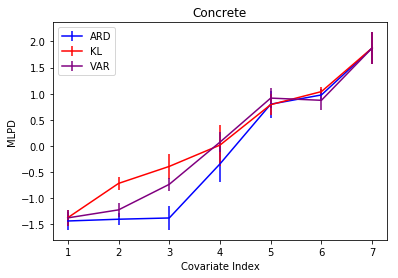

In [89]:
# Plot results
fig, ax = plt.subplots(1,1)
plot_mlpd(ax, mlpd_concrete, 'Concrete')
plt.xlabel('Covariate Index')
plt.show()

In [83]:
# Boston Housing data
data_link='https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
colnames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df_Boston = pd.read_csv(data_link, delim_whitespace=True, header=None)
df_Boston.columns = colnames
df_Boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [84]:
X_Boston = df_Boston.iloc[:,:-1]
y_Boston = df_Boston.iloc[:,-1]
print('Data Shape:', X_Boston.shape)
print('Output Shape:', y_Boston.shape)
mlpd_Boston = perform_GP_fitting(X_Boston,y_Boston)

  0%|          | 0/10 [00:00<?, ?it/s]

Data Shape: (506, 13)
Output Shape: (506,)
Testing full model


 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning:invalid value encountered in sqrt
 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning:invalid value encountered in sqrt
100%|██████████| 10/10 [02:52<00:00, 17.27s/it]


Testing Covariates
0
[4, 9, 12, 7, 8, 5, 0, 6, 10, 11, 3, 2, 1]
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
1
[10, 6, 3, 2, 1, 4, 5, 9, 12, 8, 7, 0, 11]
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
2
[9, 8, 7, 6, 4, 2, 5, 12, 0, 10, 3, 11, 1]
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1


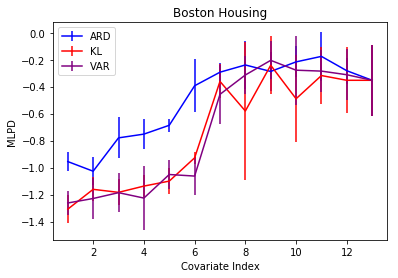

In [90]:
# Plot Boston housing
fig, ax = plt.subplots(1,1)
plot_mlpd(ax, mlpd_Boston, 'Boston Housing')
plt.xlabel('Covariate Index')
plt.show()

In [167]:
# NOTE: CRIME DATA IS VERY LARGE AND TAKES TOO LONG WITHOUT SAMPLING METHODS
# Crime data
data_link = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
df_crime = pd.read_csv(data_link, delim_whitespace=False, header=None)

# Drop the 4th column because it is strings only
df_crime = df_crime.drop(columns=[3])

# Replace '?' with nan
df_crime = df_crime.replace({'?': np.nan})

# Convert to numeric
df_crime = df_crime.apply(pd.to_numeric, args=('coerce',))

# Fill missing with mean imputation:
df_crime = df_crime.apply(lambda x: x.fillna(x.mean()),axis=0)

df_crime = df_crime.sample(n=300, random_state=10)

print('Data Shape:', df_crime.shape)
df_crime.head()

Data Shape: (300, 127)


,0,1,2,4,5,6,7,8,9,10,...,118,119,120,121,122,123,124,125,126,127
761,41,58.826829,46188.336597,4,0.02,0.31,0.00,0.97,0.04,0.04,...,0.04,0.13,0.02,0.163103,0.076708,0.698589,0.440439,0.0,0.195078,0.21
577,25,17.000000,56130.000000,3,0.02,0.54,0.00,0.98,0.06,0.01,...,0.03,0.19,0.27,0.163103,0.076708,0.698589,0.440439,0.0,0.195078,0.04
1610,24,58.826829,46188.336597,9,0.02,0.37,0.53,0.55,0.09,0.02,...,0.03,0.17,0.06,0.163103,0.076708,0.698589,0.440439,0.0,0.195078,0.91
955,1,58.826829,46188.336597,5,0.04,0.67,1.00,0.00,0.00,0.00,...,0.07,0.11,0.18,0.163103,0.076708,0.698589,0.440439,0.0,0.195078,1.00
1800,39,33.000000,10030.000000,10,0.01,0.35,0.01,0.99,0.02,0.01,...,0.02,0.18,0.00,0.163103,0.076708,0.698589,0.440439,0.0,0.195078,0.07


In [136]:
# # Run the GP model on this dataset:
# X_crime = df_crime.iloc[:,:-1]
# y_crime= df_crime.iloc[:,-1]
# print('Data Shape:', X_crime.shape)
# print('Output Shape:', y_crime.shape)
# mlpd_crime = perform_GP_fitting(X_crime,y_crime)

In [ ]:
# # Plot crime data
# fig, ax = plt.subplots(1,1)
# plot_mlpd(ax, mlpd_crime, 'Crime')
# plt.xlabel('Covariate Index')
# plt.show()

In [151]:
data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
df_cars = pd.read_csv(data_link, delim_whitespace=True, header=None)

# Initial size:
print('Initial Size:', df_cars.shape)

# Drop the last column because it's string
df_cars = df_cars.drop(columns=[8])

# Replace '?' with nan
df_cars = df_cars.replace({'?': np.nan})

# Drop imputation
df_cars = df_cars.dropna()
print('Final Size:', df_cars.shape)

# Print the head
df_cars.head()

Initial Size: (398, 9)
Final Size: (392, 8)


,0,1,2,3,4,5,6,7
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [152]:
X_cars = df_cars.iloc[:,1::]
y_cars = df_cars.iloc[:,0]
print('Data Shape:', X_cars.shape)
print('Output Shape:', y_cars.shape)
mlpd_cars = perform_GP_fitting(X_cars,y_cars)


  0%|          | 0/10 [00:00<?, ?it/s]

Data Shape: (392, 7)
Output Shape: (392,)
Testing full model


 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning:invalid value encountered in sqrt

 10%|█         | 1/10 [00:04<00:43,  4.78s/it] /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning:invalid value encountered in sqrt

Exception in thread Thread-21:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 10/10 [00:41<00:00,  4.18s/it]
 /anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:Data with input dtype object was converted to float64 by the scale function.


Testing Covariates
0
[6, 5, 1, 3, 0, 2, 4]
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
1
[1, 0, 3, 5, 6, 2, 4]
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
2
[3, 2, 1, 5, 6, 0, 4]
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1


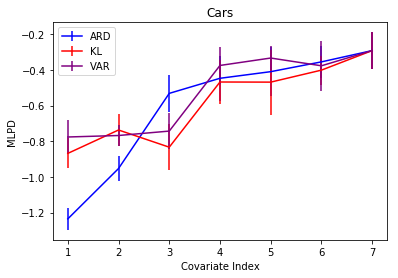

In [153]:
# Plot car data
fig, ax = plt.subplots(1,1)
plot_mlpd(ax, mlpd_cars, 'Cars')
plt.xlabel('Covariate Index')
plt.show()

In [192]:
# Read in the data
df_facebook = pd.read_csv('dataset_Facebook.csv', delimiter=';')

# Convert second column to categorical indices
df_facebook = df_facebook.drop(columns=['Type'])

# Print data shape
print('Shape of Data', df_facebook.shape)

# Fill nans 
df_facebook = df_facebook.dropna()

df_facebook.head()

Shape of Data (500, 18)


,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [193]:
X_facebook = df_facebook.drop(columns=['Page total likes'])
y_facebook = df_facebook['Page total likes']

print('Data Shape:', X_facebook.shape)
print('Output Shape:', y_facebook.shape)
mlpd_facebook = perform_GP_fitting(X_facebook,y_facebook)

 /anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:Data with input dtype int64 was converted to float64 by the scale function.
  0%|          | 0/10 [00:00<?, ?it/s]

Data Shape: (495, 17)
Output Shape: (495,)
Testing full model


 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning:invalid value encountered in sqrt
 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning:invalid value encountered in sqrt
100%|██████████| 10/10 [02:56<00:00, 17.62s/it]


Testing Covariates
0
[1, 12, 8, 2, 15, 14, 13, 3, 5, 11, 0, 4, 9, 7, 16, 10, 6]
Number of Features: 16
Number of Features: 15
Number of Features: 14


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide


Number of Features: 13
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
1
[16, 7, 4, 5, 11, 10, 9, 6, 1, 8, 12, 14, 15, 13, 2, 3, 0]
Number of Features: 16
Number of Features: 15
Number of Features: 14
Number of Features: 13
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
2
[16, 11, 6, 7, 15, 8, 12, 13, 14, 1, 2, 3, 0, 5, 4, 9, 10]
Number of Features: 16
Number of Features: 15
Number of Features: 14
Number of Features: 13
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Nu

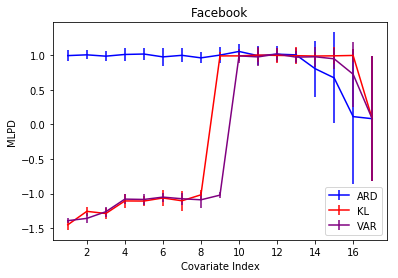

In [194]:
# Plot facebook data
fig, ax = plt.subplots(1,1)
plot_mlpd(ax, mlpd_facebook, 'Facebook')
plt.xlabel('Covariate Index')
plt.show()

In [164]:
data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data'
df_park = pd.read_csv(data_link, delim_whitespace=False)

# Take a subsample of this data for regression (just to reduce the data size)
df_park = df_park.sample(n=300, random_state=10)

# Size:
print(df_park.shape)
df_park.head()

(300, 22)


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
1683,12,62,0,112.350,15.000,21.538,0.00271,0.000018,0.00124,0.00160,...,0.167,0.00903,0.01223,0.01846,0.02708,0.011654,24.048,0.60077,0.56337,0.14821
3421,25,76,0,105.370,30.335,49.419,0.00389,0.000040,0.00113,0.00191,...,0.167,0.00716,0.01123,0.02096,0.02148,0.012540,21.026,0.58322,0.55835,0.16165
1474,10,58,0,17.316,12.000,19.000,0.00248,0.000021,0.00097,0.00129,...,0.194,0.01090,0.01196,0.01581,0.03269,0.010489,25.902,0.59655,0.59823,0.11962
42,1,72,0,131.640,34.109,44.146,0.00389,0.000025,0.00149,0.00166,...,0.227,0.01083,0.01298,0.02097,0.03249,0.020530,24.184,0.58492,0.59993,0.20018
1302,9,68,0,28.344,17.000,23.616,0.00600,0.000047,0.00318,0.00298,...,0.183,0.00905,0.00993,0.01445,0.02716,0.013919,25.299,0.53042,0.71969,0.19645


In [165]:
X_park = df_park.drop(columns=['motor_UPDRS','total_UPDRS'])
y_park = df_park['total_UPDRS']

print('Data Shape:', X_park.shape)
print('Output Shape:', y_park.shape)
mlpd_park = perform_GP_fitting(X_park,y_park)

  0%|          | 0/10 [00:00<?, ?it/s]

Data Shape: (300, 20)
Output Shape: (300,)
Testing full model


 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning:invalid value encountered in sqrt
 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning:invalid value encountered in sqrt
 /anaconda3/lib/python3.6/site-packages/GPy/likelihoods/gaussian.py:326: RuntimeWarning:invalid value encountered in log
100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


Testing Covariates
0
[0, 1, 3, 2, 15, 9, 7, 10, 12, 14, 11, 4, 6, 8, 13, 5, 16, 18, 19, 17]
Number of Features: 19
Number of Features: 18
Number of Features: 17
Number of Features: 16
Number of Features: 15


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add


Number of Features: 14
Number of Features: 13
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide


Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
1
[19, 18, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0]
Number of Features: 19


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Number of Features: 18
Number of Features: 17
Number of Features: 16
Number of Features: 15
Number of Features: 14
Number of Features: 13
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1
2
[19, 11, 5, 6, 7, 8, 10, 9, 12, 13, 14, 15, 16, 3, 1, 2, 18, 17, 4, 0]
Number of Features: 19
Number of Features: 18
Number of Features: 17
Number of Features: 16
Number of Features: 15
Number of Features: 14
Number of Features: 13
Number of Features: 12
Number of Features: 11
Number of Features: 10
Number of Features: 9
Number of Features: 8
Number of Features: 7
Number of Features: 6
Number of Features: 5
Number of Features: 4
Number of Features: 3
Number of Features: 2
Number of Features: 1


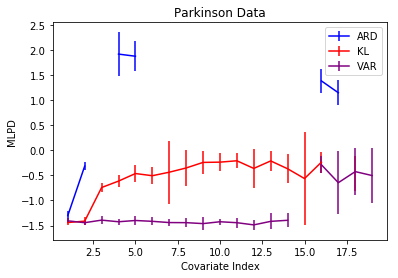

In [166]:
# Plot parkinson data
fig, ax = plt.subplots(1,1)
plot_mlpd(ax, mlpd_park, 'Parkinson Data')
plt.xlabel('Covariate Index')
plt.show()

In [204]:
# # Plot all together
# mlpd_all = [mlpd_concrete, mlpd_Boston]
# fig, ax_full = plt.subplots(2,1, figsize=(6,6))
# titles =['Concrete', 'Boston Housing']
# # Plot the MLPD estimates for each of the datasets
# for ax2, mlpd, title in zip(ax_full, mlpd_all, titles):
#     plot_mlpd(ax2, mlpd, title)
# plt.xlabel('Number of Covariates')
# plt.show()